# Metal Backend for Needle

Metal is Apple's graphics and compute API for Apple Silicon GPUs, similar
to CUDA for NVIDIA GPUs. We have written a Metal backend for Needle using
Metal Shading Language (MSL), analogous to the CUDA backend. We have also
written a Metal backend using Metal Performance Shaders (MPS), a library of 
highly optimized GPU kernels for e.g. matrix multiplication. PyTorch's 
Metal backend is built on top of MPS.

We benchmarked the following backends:

- PyTorch CPU
- PyTorch MPS
- Needle CPU
- Needle MSL
- Needle MPS

### Setup

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

import sys
import time

sys.path.append('./python')
import needle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
torch.set_num_threads(1)

rng = np.random.default_rng(0)

Using needle backend


In [2]:
device_torch_cpu = torch.device("cpu")
device_torch_mps = torch.device("mps") if torch.backends.mps.is_available() else None
device_needle_cpu = needle.cpu()
device_needle_msl = needle.msl()
device_needle_mps = needle.mps()

def torch_mps_synchronize():
    if torch.backends.mps.is_available():
        torch.mps.synchronize()

def needle_msl_synchronize():
    needle.backend_ndarray.ndarray_backend_msl.synchronize()

def needle_mps_synchronize():
    needle.backend_ndarray.ndarray_backend_mps.synchronize()

In [3]:
def benchmark_fn(fn, warmup=5, iters=20, sync_fn=None):
    # warmup
    for _ in range(warmup):
        fn()
        if sync_fn is not None:
            sync_fn()
    # timed
    times = []
    for _ in range(iters):
        if sync_fn is not None:
            sync_fn()   # optional: ensure previous work is done
        t0 = time.perf_counter()
        fn()
        if sync_fn is not None:
            sync_fn()
        t1 = time.perf_counter()
        times.append((t1 - t0) * 1e3)  # ms
    return np.mean(times), np.std(times)

In [4]:
# fixed color palette per backend for plotting
COLOR_MAP = {
    ("pytorch", "cpu"): "#1f77b4",   # blue
    ("pytorch", "mps"): "#ff7f0e",   # orange
    ("needle",  "cpu"): "#2ca02c",   # green
    ("needle",  "msl"): "#d62728",   # red
    ("needle",  "mps"): "#9467bd",   # purple
}


## Matmul

### Matmul Benchmarking Helpers

In [5]:
# PyTorch CPU

def make_matmul_inputs_torch_cpu(m, k, n):
    A = torch.from_numpy(
        rng.standard_normal((m, k), dtype=np.float32)
    ).to(device_torch_cpu, dtype=torch.float32)
    B = torch.from_numpy(
        rng.standard_normal((k, n), dtype=np.float32)
    ).to(device_torch_cpu, dtype=torch.float32)
    return A, B

def benchmark_torch_cpu_matmul(A, B):
    def fn():
        with torch.no_grad():
            _ = A @ B
    return benchmark_fn(fn, warmup=10, iters=50, sync_fn=None)


# PyTorch MPS

def make_matmul_inputs_torch_mps(m, k, n):
    A = torch.from_numpy(
        rng.standard_normal((m, k), dtype=np.float32)
    ).to(device_torch_mps, dtype=torch.float32)
    B = torch.from_numpy(
        rng.standard_normal((k, n), dtype=np.float32)
    ).to(device_torch_mps, dtype=torch.float32)
    return A, B

def benchmark_torch_mps_matmul(A, B):
    def fn():
        with torch.no_grad():
            _ = A @ B
    return benchmark_fn(fn, warmup=10, iters=50, sync_fn=torch_mps_synchronize)

In [6]:
# Needle CPU

def make_matmul_inputs_needle_cpu(m, k, n):
    A = needle.Tensor(
        rng.standard_normal((m, k), dtype=np.float32),
        device=device_needle_cpu,
        dtype="float32",
        requires_grad=False
    )
    B = needle.Tensor(
        rng.standard_normal((k, n), dtype=np.float32),
        device=device_needle_cpu,
        dtype="float32",
        requires_grad=False
    )
    return A, B

def benchmark_needle_cpu_matmul(A, B):
    def fn():
        _ = A @ B
    return benchmark_fn(fn, warmup=10, iters=50, sync_fn=None)


# Needle MSL

def make_matmul_inputs_needle_msl(m, k, n):
    A = needle.Tensor(
        rng.standard_normal((m, k), dtype=np.float32),
        device=device_needle_msl,
        dtype="float32",
        requires_grad=False
    )
    B = needle.Tensor(
        rng.standard_normal((k, n), dtype=np.float32),
        device=device_needle_msl,
        dtype="float32",
        requires_grad=False
    )
    return A, B

def benchmark_needle_msl_matmul(A, B):
    def fn():
        _ = A @ B
    return benchmark_fn(fn, warmup=10, iters=50, sync_fn=needle_msl_synchronize)


# Needle MPS

def make_matmul_inputs_needle_mps(m, k, n):
    A = needle.Tensor(
        rng.standard_normal((m, k), dtype=np.float32),
        device=device_needle_mps,
        dtype="float32",
        requires_grad=False
    )
    B = needle.Tensor(
        rng.standard_normal((k, n), dtype=np.float32),
        device=device_needle_mps,
        dtype="float32",
        requires_grad=False
    )
    return A, B

def benchmark_needle_mps_matmul(A, B):
    def fn():
        _ = A @ B
    return benchmark_fn(fn, warmup=10, iters=50, sync_fn=needle_mps_synchronize)

In [7]:
def run_all_matmul_benchmarks(shapes, run_needle_cpu=False):
    results = []

    for label, m, k, n in shapes:
        print(f"\n=== Shape {label}: A=({m},{k}), B=({k},{n}) ===")

        # PyTorch CPU
        A_torch_cpu, B_torch_cpu = make_matmul_inputs_torch_cpu(m, k, n)
        assert str(A_torch_cpu.device) == 'cpu', A_torch_cpu.device
        mean_ms, std_ms = benchmark_torch_cpu_matmul(A_torch_cpu, B_torch_cpu)
        gflops = (2.0 * m * k * n) / (mean_ms / 1e3) / 1e9 
        print(f"  PyTorch CPU: {mean_ms:.3f} ± {std_ms:.3f} ms, {gflops:.2f} GFLOP/s")
        results.append(dict(
            label=label,
            framework="pytorch",
            device="cpu",
            m=m, k=k, n=n,
            mean_ms=mean_ms,
            std_ms=std_ms,
            gflops=gflops,
        ))

        # PyTorch MPS (if available)
        if device_torch_mps is not None:
            A_torch_mps, B_torch_mps = make_matmul_inputs_torch_mps(m, k, n)
            assert str(A_torch_mps.device).split(':')[0] == 'mps', A_torch_mps.device
            mean_ms, std_ms = benchmark_torch_mps_matmul(A_torch_mps, B_torch_mps)
            gflops = (2.0 * m * k * n) / (mean_ms / 1e3) / 1e9
            print(f"  PyTorch MPS: {mean_ms:.3f} ± {std_ms:.3f} ms, {gflops:.2f} GFLOP/s")
            results.append(dict(
                label=label,
                framework="pytorch",
                device="mps",
                m=m, k=k, n=n,
                mean_ms=mean_ms,
                std_ms=std_ms,
                gflops=gflops,
            ))

        # Needle CPU
        if run_needle_cpu:
            A_needle_cpu, B_needle_cpu = make_matmul_inputs_needle_cpu(m, k, n)
            assert A_needle_cpu.device == device_needle_cpu, A_needle_cpu.device
            mean_ms, std_ms = benchmark_needle_cpu_matmul(A_needle_cpu, B_needle_cpu)
            gflops = (2.0 * m * k * n) / (mean_ms / 1e3) / 1e9
            print(f"  Needle CPU: {mean_ms:.3f} ± {std_ms:.3f} ms, {gflops:.2f} GFLOP/s")
            results.append(dict(
                label=label,
                framework="needle",
                device="cpu",
                m=m, k=k, n=n,
                mean_ms=mean_ms,
                std_ms=std_ms,
                gflops=gflops,
            ))

        # Needle MSL
        A_needle_msl, B_needle_msl = make_matmul_inputs_needle_msl(m, k, n)
        assert A_needle_msl.device == device_needle_msl, A_needle_msl.device
        mean_ms, std_ms = benchmark_needle_msl_matmul(A_needle_msl, B_needle_msl)
        gflops = (2.0 * m * k * n) / (mean_ms / 1e3) / 1e9
        print(f"  Needle MSL: {mean_ms:.3f} ± {std_ms:.3f} ms, {gflops:.2f} GFLOP/s")
        results.append(dict(
            label=label,
            framework="needle",
            device="msl",
            m=m, k=k, n=n,
            mean_ms=mean_ms,
            std_ms=std_ms,
            gflops=gflops,
        ))

        # Needle MPS
        A_needle_mps, B_needle_mps = make_matmul_inputs_needle_mps(m, k, n)
        assert A_needle_mps.device == device_needle_mps, A_needle_mps.device
        mean_ms, std_ms = benchmark_needle_mps_matmul(A_needle_mps, B_needle_mps)
        gflops = (2.0 * m * k * n) / (mean_ms / 1e3) / 1e9
        print(f"  Needle MPS: {mean_ms:.3f} ± {std_ms:.3f} ms, {gflops:.2f} GFLOP/s")
        results.append(dict(
            label=label,
            framework="needle",
            device="mps",
            m=m, k=k, n=n,
            mean_ms=mean_ms,
            std_ms=std_ms,
            gflops=gflops,
        ))

    return pd.DataFrame(results)

In [8]:
def plot_matmul_gflops_grouped(df, only_needle=False):
    labels = df["label"].unique()
    
    # Unique backend combinations
    groups = df[["framework", "device"]].drop_duplicates()
    groups = list(groups.itertuples(index=False, name=None)) 
    # e.g. [("pytorch","cpu"), ("pytorch","mps"), ("needle","cpu")]
    if only_needle:
        groups = [g for g in groups if g[0] == "needle"] 

    x = np.arange(len(labels))
    width = 0.8 / len(groups)   # auto-size bars nicely

    plt.figure(figsize=(16, 6))

    for i, (framework, device) in enumerate(groups):
        sub = df[(df["framework"] == framework) & (df["device"] == device)]
        sub = sub.set_index("label").loc[labels]

        backend_label = f"{framework.capitalize()} {device.upper()}"
        color = COLOR_MAP[(framework, device)]

        plt.bar(
            x + i * width,
            sub["gflops"],
            width,
            label=backend_label,
            color=color,
        )

    plt.xticks(x + width * (len(groups)-1)/2, labels, rotation=45, ha="right")
    plt.ylabel("GFLOP/s")
    plt.title("Matmul Performance by Backend")
    plt.legend()
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

### Run Matmul Benchmarks

In [9]:
# (label, m, k, n) for A: (m, k), B: (k, n)
MATMUL_SHAPES = [
    # Square-ish
    ("square_1024",      1024, 1024, 1024),
    ("square_2048",      2048, 2048, 2048),
    ("square_4096",      4096, 4096, 4096),

    # MLP-like (batch_size, in_dim, out_dim)
    ("mlp_64x1024x4096",  64, 1024, 4096),
    ("mlp_256x1024x4096", 256, 1024, 4096),
    ("mlp_64x4096x1024",  64, 4096, 1024),
    ("mlp_64x2048x8192",  64, 2048, 8192),
    ("mlp_32x512x2048",   32,  512, 2048),
]

In [10]:
df_matmul = run_all_matmul_benchmarks(MATMUL_SHAPES, run_needle_cpu=True)
df_matmul


=== Shape square_1024: A=(1024,1024), B=(1024,1024) ===
  PyTorch CPU: 1.136 ± 0.073 ms, 1890.46 GFLOP/s
  PyTorch MPS: 0.854 ± 0.051 ms, 2514.59 GFLOP/s
  Needle CPU: 55.524 ± 0.432 ms, 38.68 GFLOP/s
  Needle MSL: 4.307 ± 0.040 ms, 498.63 GFLOP/s
  Needle MPS: 1.052 ± 0.041 ms, 2041.31 GFLOP/s

=== Shape square_2048: A=(2048,2048), B=(2048,2048) ===
  PyTorch CPU: 10.229 ± 0.082 ms, 1679.46 GFLOP/s
  PyTorch MPS: 4.821 ± 0.076 ms, 3563.44 GFLOP/s
  Needle CPU: 484.787 ± 42.800 ms, 35.44 GFLOP/s
  Needle MSL: 32.220 ± 0.126 ms, 533.21 GFLOP/s
  Needle MPS: 5.786 ± 0.133 ms, 2968.99 GFLOP/s

=== Shape square_4096: A=(4096,4096), B=(4096,4096) ===
  PyTorch CPU: 85.434 ± 3.310 ms, 1608.72 GFLOP/s
  PyTorch MPS: 36.229 ± 0.139 ms, 3793.61 GFLOP/s
  Needle CPU: 5254.382 ± 167.632 ms, 26.16 GFLOP/s
  Needle MSL: 286.676 ± 2.034 ms, 479.42 GFLOP/s
  Needle MPS: 41.460 ± 0.589 ms, 3314.96 GFLOP/s

=== Shape mlp_64x1024x4096: A=(64,1024), B=(1024,4096) ===
  PyTorch CPU: 0.909 ± 0.130 ms, 590

,label,framework,device,m,k,n,mean_ms,std_ms,gflops
0,square_1024,pytorch,cpu,1024,1024,1024,1.135960,0.072519,1890.457011
1,square_1024,pytorch,mps,1024,1024,1024,0.854008,0.051175,2514.593237
2,square_1024,needle,cpu,1024,1024,1024,55.524401,0.432329,38.676395
3,square_1024,needle,msl,1024,1024,1024,4.306741,0.039603,498.633131
4,square_1024,needle,mps,1024,1024,1024,1.052012,0.040804,2041.310238
5,square_2048,pytorch,cpu,2048,2048,2048,10.229419,0.082312,1679.456955
6,square_2048,pytorch,mps,2048,2048,2048,4.821143,0.075810,3563.442895
7,square_2048,needle,cpu,2048,2048,2048,484.787459,42.799698,35.437941
8,square_2048,needle,msl,2048,2048,2048,32.219814,0.125593,533.208202
9,square_2048,needle,mps,2048,2048,2048,5.786432,0.133232,2968.991926


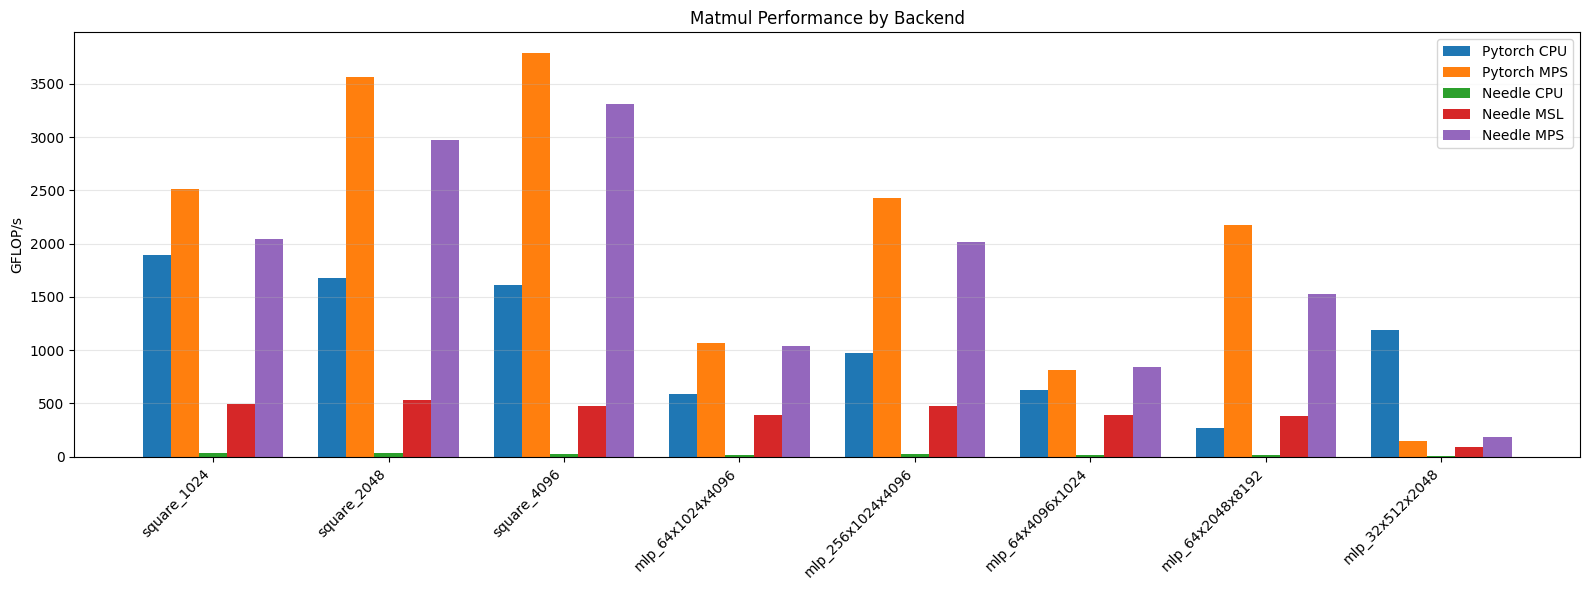

In [11]:
plot_matmul_gflops_grouped(df_matmul, only_needle=False)

## MLP

### MLP Benchmarking Helpers

In [12]:
def init_linear_weights(in_dim, out_dim):
    w = rng.standard_normal((out_dim, in_dim), dtype=np.float32) * 0.02
    b = np.zeros((out_dim,), dtype=np.float32)
    return w, b

In [13]:
# PyTorch MLP
class TorchMLP(torch.nn.Module):
    def __init__(self, layer_sizes, device=device_torch_cpu):
        super().__init__()
        layers = []
        for i in range(len(layer_sizes) - 1):
            in_dim = layer_sizes[i]
            out_dim = layer_sizes[i + 1]
            linear = torch.nn.Linear(in_dim, out_dim, bias=True)

            # Initialize weights using our function for consistency
            w, b = init_linear_weights(in_dim, out_dim)
            with torch.no_grad():
                linear.weight.copy_(torch.from_numpy(w).to(device=device))
                linear.bias.copy_(torch.from_numpy(b).to(device=device))
            
            layers.append(linear)
            if i < len(layer_sizes) - 2:
                layers.append(torch.nn.ReLU())
        self.net = torch.nn.Sequential(*layers)
        # Optional: ensure any future buffers/params are on device too:
        self.to(device)

    def forward(self, x):
        return self.net(x)

# Needle MLP
class NeedleMLP(needle.nn.Module):
    def __init__(self, layer_sizes, device=device_needle_cpu):
        super().__init__()
        layers = []
        for i in range(len(layer_sizes) - 1):
            in_dim = layer_sizes[i]
            out_dim = layer_sizes[i + 1]
            linear = needle.nn.Linear(in_dim, out_dim, bias=True, device=device)

            # Initialize weights using our function for consistency
            w, b = init_linear_weights(in_dim, out_dim)
            # Transpose to (in_dim, out_dim) for Needle
            linear.weight = needle.nn.Parameter(
                needle.Tensor(w.T, device=device, dtype="float32")
            )
            # Reshape to (1, out_dim) for Needle
            linear.bias = needle.nn.Parameter(
                needle.Tensor(b.reshape(1, -1), device=device, dtype="float32")
            )

            layers.append(linear)
            if i < len(layer_sizes) - 2:
                layers.append(needle.nn.ReLU())
        self.net = needle.nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [14]:
# PyTorch CPU 

def make_torch_cpu_model_and_data(layer_sizes, batch_size=64):
    model = TorchMLP(layer_sizes, device=device_torch_cpu)
    x = torch.from_numpy(
        rng.standard_normal((batch_size, layer_sizes[0]), dtype=np.float32)
    ).to(device_torch_cpu, dtype=torch.float32)
    y = torch.from_numpy(
        rng.integers(0, layer_sizes[-1], size=(batch_size,), dtype=np.int64)
    ).to(device_torch_cpu, dtype=torch.int64)
    return model, x, y

def benchmark_torch_cpu_mlp_train_step(model, x, y, criterion, optimizer):
    x = x.to(device_torch_cpu)
    y = y.to(device_torch_cpu)

    def fn():
        optimizer.zero_grad(set_to_none=True)
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
    return benchmark_fn(fn, warmup=10, iters=50, sync_fn=None)


# PyTorch MPS

def make_torch_mps_model_and_data(layer_sizes, batch_size=64):
    model = TorchMLP(layer_sizes, device=device_torch_mps)
    x = torch.from_numpy(
        rng.standard_normal((batch_size, layer_sizes[0]), dtype=np.float32)
    ).to(device_torch_mps, dtype=torch.float32)
    y = torch.from_numpy(
        rng.integers(0, layer_sizes[-1], size=(batch_size,), dtype=np.int64)
    ).to(device_torch_mps, dtype=torch.int64)
    return model, x, y

def benchmark_torch_mps_mlp_train_step(model, x, y, criterion, optimizer):
    x = x.to(device_torch_mps)
    y = y.to(device_torch_mps)

    def fn():
        optimizer.zero_grad(set_to_none=True)
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
    return benchmark_fn(fn, warmup=10, iters=50, sync_fn=torch_mps_synchronize)


In [15]:
# Needle CPU

def make_needle_cpu_model_and_data(layer_sizes, batch_size=64):
    model = NeedleMLP(layer_sizes, device=device_needle_cpu)
    x = needle.Tensor(
        rng.standard_normal((batch_size, layer_sizes[0]), dtype=np.float32),
        device=device_needle_cpu,
        dtype="float32",
        requires_grad=False
    )
    y = needle.Tensor(
        rng.integers(0, layer_sizes[-1], size=(batch_size,), dtype=np.int64),
        device=device_needle_cpu,
        dtype="float32",
        requires_grad=False
    )
    return model, x, y

def benchmark_needle_cpu_mlp_train_step(model, x, y, criterion, optimizer):
    assert x.device == device_needle_cpu, x.device
    assert y.device == device_needle_cpu, y.device

    def fn():
        optimizer.reset_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
    return benchmark_fn(fn, warmup=10, iters=50, sync_fn=None)


# Needle MSL

def make_needle_msl_model_and_data(layer_sizes, batch_size=64):
    model = NeedleMLP(layer_sizes, device=device_needle_msl)
    x = needle.Tensor(
        rng.standard_normal((batch_size, layer_sizes[0]), dtype=np.float32),
        device=device_needle_msl,
        dtype="float32",
        requires_grad=False
    )
    y = needle.Tensor(
        rng.integers(0, layer_sizes[-1], size=(batch_size,), dtype=np.int64),
        device=device_needle_msl,
        dtype="float32",
        requires_grad=False
    )
    return model, x, y

def benchmark_needle_msl_mlp_train_step(model, x, y, criterion, optimizer):
    assert x.device == device_needle_msl, x.device
    assert y.device == device_needle_msl, y.device

    def fn():
        optimizer.reset_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
    return benchmark_fn(fn, warmup=10, iters=50, sync_fn=needle_msl_synchronize)


# Needle MPS

def make_needle_mps_model_and_data(layer_sizes, batch_size=64):
    model = NeedleMLP(layer_sizes, device=device_needle_mps)
    x = needle.Tensor(
        rng.standard_normal((batch_size, layer_sizes[0]), dtype=np.float32),
        device=device_needle_mps,
        dtype="float32",
        requires_grad=False
    )
    y = needle.Tensor(
        rng.integers(0, layer_sizes[-1], size=(batch_size,), dtype=np.int64),
        device=device_needle_mps,
        dtype="float32",
        requires_grad=False
    )
    return model, x, y

def benchmark_needle_mps_mlp_train_step(model, x, y, criterion, optimizer):
    assert x.device == device_needle_mps, x.device
    assert y.device == device_needle_mps, y.device

    def fn():
        optimizer.reset_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
    return benchmark_fn(fn, warmup=10, iters=50, sync_fn=needle_mps_synchronize)

In [16]:
def run_all_mlp_benchmarks(shapes):
    results = []

    for label, layer_sizes, batch_size in shapes:

        print(f"\n=== MLP Shape {label}: layers={layer_sizes}, batch_size={batch_size} ===")

        # PyTorch CPU
        model_torch_cpu, x_torch_cpu, y_torch_cpu = make_torch_cpu_model_and_data(
            layer_sizes, batch_size
        )
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model_torch_cpu.parameters(), lr=0.01)

        mean_ms, std_ms = benchmark_torch_cpu_mlp_train_step(
            model_torch_cpu, x_torch_cpu, y_torch_cpu, criterion, optimizer
        )
        print(f"  PyTorch CPU: {mean_ms:.3f} ± {std_ms:.3f} ms")
        results.append(dict(
            label=label,
            framework="pytorch",
            device="cpu",
            mean_ms=mean_ms,
            std_ms=std_ms,
        ))

        # PyTorch MPS
        if device_torch_mps is not None:
            model_torch_mps, x_torch_mps, y_torch_mps = make_torch_mps_model_and_data(
                layer_sizes, batch_size
            )
            criterion = torch.nn.CrossEntropyLoss()
            optimizer = torch.optim.SGD(model_torch_mps.parameters(), lr=0.01)

            mean_ms, std_ms = benchmark_torch_mps_mlp_train_step(
                model_torch_mps, x_torch_mps, y_torch_mps, criterion, optimizer
            )
            print(f"  PyTorch MPS: {mean_ms:.3f} ± {std_ms:.3f} ms")
            results.append(dict(
                label=label,
                framework="pytorch",
                device="mps",
                mean_ms=mean_ms,
                std_ms=std_ms,
            ))
        
        # Needle CPU
        model_needle_cpu, x_needle_cpu, y_needle_cpu = make_needle_cpu_model_and_data(
            layer_sizes, batch_size
        )
        criterion = needle.nn.SoftmaxLoss()
        optimizer = needle.optim.SGD(model_needle_cpu.parameters(), lr=0.01)

        mean_ms, std_ms = benchmark_needle_cpu_mlp_train_step(
            model_needle_cpu, x_needle_cpu, y_needle_cpu, criterion, optimizer
        )
        print(f"  Needle CPU: {mean_ms:.3f} ± {std_ms:.3f} ms")
        results.append(dict(
            label=label,
            framework="needle",
            device="cpu",
            mean_ms=mean_ms,
            std_ms=std_ms,
        ))

        # Needle MSL
        model_needle_msl, x_needle_msl, y_needle_msl = make_needle_msl_model_and_data(
            layer_sizes, batch_size
        )
        criterion = needle.nn.SoftmaxLoss()
        optimizer = needle.optim.SGD(model_needle_msl.parameters(), lr=0.01)

        mean_ms, std_ms = benchmark_needle_msl_mlp_train_step(
            model_needle_msl, x_needle_msl, y_needle_msl, criterion, optimizer
        )
        print(f"  Needle MSL: {mean_ms:.3f} ± {std_ms:.3f} ms")
        results.append(dict(
            label=label,
            framework="needle",
            device="msl",
            mean_ms=mean_ms,
            std_ms=std_ms,
        ))

        # Needle MPS
        model_needle_mps, x_needle_mps, y_needle_mps = make_needle_mps_model_and_data(
            layer_sizes, batch_size
        )
        criterion = needle.nn.SoftmaxLoss()
        optimizer = needle.optim.SGD(model_needle_mps.parameters(), lr=0.01)

        mean_ms, std_ms = benchmark_needle_mps_mlp_train_step(
            model_needle_mps, x_needle_mps, y_needle_mps, criterion, optimizer
        )
        print(f"  Needle MPS: {mean_ms:.3f} ± {std_ms:.3f} ms")
        results.append(dict(
            label=label,
            framework="needle",
            device="mps",
            mean_ms=mean_ms,
            std_ms=std_ms,
        ))

    return pd.DataFrame(results)

In [17]:
def plot_mlp_mean_ms_grouped(df, only_needle=False, show_needle_cpu=True):
    labels = df["label"].unique()
    
    groups = df[["framework", "device"]].drop_duplicates()
    groups = list(groups.itertuples(index=False, name=None))
    if only_needle:
        groups = [g for g in groups if g[0] == "needle"]
    if not show_needle_cpu:
        groups = [g for g in groups if not (g[0] == "needle" and g[1] == "cpu")]

    x = np.arange(len(labels))
    width = 0.8 / max(1, len(groups))

    plt.figure(figsize=(16, 6))
    for i, (framework, device) in enumerate(groups):
        sub = df[(df["framework"] == framework) & (df["device"] == device)].set_index("label")
        sub = sub.loc[labels]  # keep original order
        backend_label = f"{framework.capitalize()} {device.upper()}"
        color = COLOR_MAP[(framework, device)]
        plt.bar(x + i * width, sub["mean_ms"], width, label=backend_label, color=color)

    plt.xticks(x + width * (len(groups)-1)/2, labels, rotation=45, ha="right")
    plt.ylabel("Mean time per train step (ms)")
    plt.title("MLP Train-Step Performance by Backend")
    plt.legend()
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

### Run MLP Benchmarks

In [18]:
# (label, layer_sizes, batch_size) 
MLP_SHAPES = [
    ("tiny-2L-128",         [128, 128, 10],                  64),
    ("med-4L-512",          [512, 512, 512, 512, 10],        64),
    ("wide-2L-1024",        [1024, 1024, 10],                64),
    ("deep-6L-1024",        [1024]*6 + [10],                 64),
    ("maxwide-2L-2048",     [2048, 2048, 10],                64),
    ("bneck-2048-64-2048",  [2048, 64, 2048, 10],            64),
]

In [19]:
df_mlp = run_all_mlp_benchmarks(MLP_SHAPES)
df_mlp


=== MLP Shape tiny-2L-128: layers=[128, 128, 10], batch_size=64 ===
  PyTorch CPU: 0.155 ± 0.074 ms
  PyTorch MPS: 1.438 ± 0.291 ms
  Needle CPU: 1.927 ± 0.161 ms
  Needle MSL: 3.306 ± 0.579 ms
  Needle MPS: 3.386 ± 0.558 ms

=== MLP Shape med-4L-512: layers=[512, 512, 512, 512, 10], batch_size=64 ===
  PyTorch CPU: 1.955 ± 3.496 ms
  PyTorch MPS: 2.279 ± 0.486 ms
  Needle CPU: 46.043 ± 1.137 ms
  Needle MSL: 5.633 ± 1.094 ms
  Needle MPS: 5.423 ± 0.587 ms

=== MLP Shape wide-2L-1024: layers=[1024, 1024, 10], batch_size=64 ===
  PyTorch CPU: 1.437 ± 0.733 ms
  PyTorch MPS: 1.168 ± 0.216 ms
  Needle CPU: 42.435 ± 0.655 ms
  Needle MSL: 4.680 ± 0.919 ms
  Needle MPS: 4.302 ± 0.560 ms

=== MLP Shape deep-6L-1024: layers=[1024, 1024, 1024, 1024, 1024, 1024, 10], batch_size=64 ===
  PyTorch CPU: 6.957 ± 0.788 ms
  PyTorch MPS: 2.596 ± 0.241 ms
  Needle CPU: 283.254 ± 4.342 ms
  Needle MSL: 17.903 ± 0.823 ms
  Needle MPS: 12.812 ± 2.013 ms

=== MLP Shape maxwide-2L-2048: layers=[2048, 2048,

,label,framework,device,mean_ms,std_ms
0,tiny-2L-128,pytorch,cpu,0.155354,0.073556
1,tiny-2L-128,pytorch,mps,1.437667,0.291378
2,tiny-2L-128,needle,cpu,1.926777,0.161129
3,tiny-2L-128,needle,msl,3.305655,0.578729
4,tiny-2L-128,needle,mps,3.386422,0.557811
5,med-4L-512,pytorch,cpu,1.955232,3.495815
6,med-4L-512,pytorch,mps,2.279374,0.485558
7,med-4L-512,needle,cpu,46.042856,1.136814
8,med-4L-512,needle,msl,5.632671,1.094243
9,med-4L-512,needle,mps,5.423389,0.587444


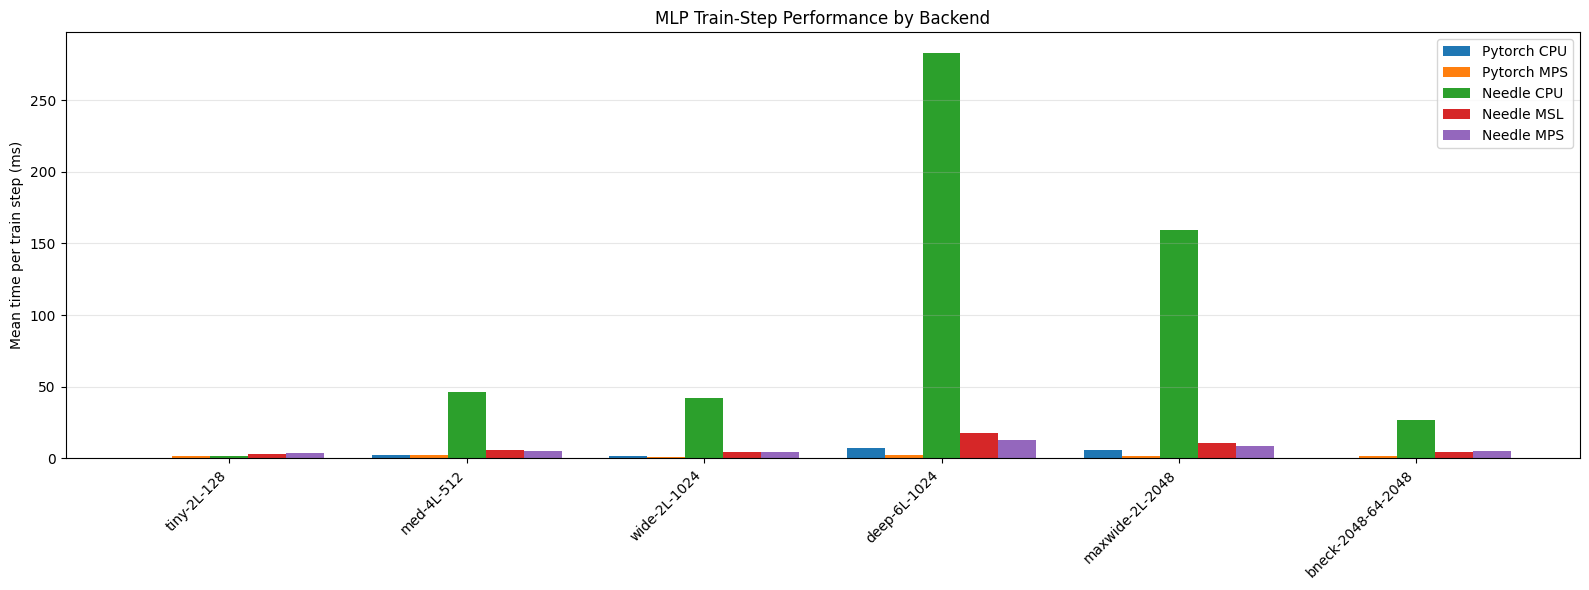

In [20]:
# With CPU Needle
plot_mlp_mean_ms_grouped(df_mlp, only_needle=False, show_needle_cpu=True)

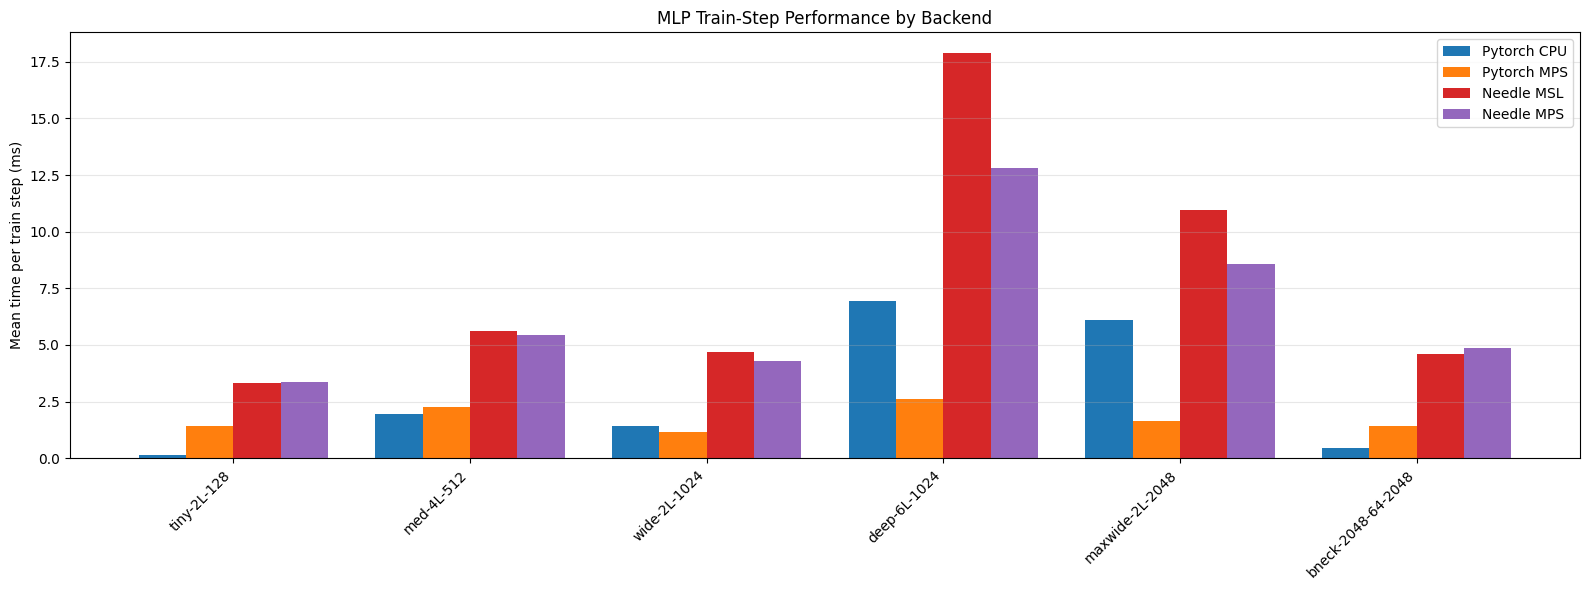

In [21]:
# Without CPU Needle
plot_mlp_mean_ms_grouped(df_mlp, only_needle=False, show_needle_cpu=False)

## ResNet9

### ResNet9 Benchmarking Helpers

In [22]:
# PyTorch ResNet9

class TorchResidual(torch.nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x

class TorchConvBN(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 device=device_torch_cpu, dtype=torch.float32):
        super().__init__()
        padding = (kernel_size - 1) // 2
        self.conv = torch.nn.Conv2d(
            in_channels, out_channels, kernel_size, 
            stride=stride, padding=padding, bias=True, device=device, dtype=dtype
        )
        self.bn = torch.nn.BatchNorm2d(out_channels, device=device, dtype=dtype)
        self.relu = torch.nn.ReLU()
        self.to(device)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class TorchResNet9(torch.nn.Module):
    def __init__(self, device=device_torch_cpu, dtype=torch.float32):
        super().__init__()

        self.layers = torch.nn.Sequential(
            TorchConvBN(3, 16, 7, stride=4, device=device, dtype=dtype),
            TorchConvBN(16, 32, 3, stride=2, device=device, dtype=dtype),
            TorchResidual(
                torch.nn.Sequential(
                    TorchConvBN(32, 32, 3, stride=1, device=device, dtype=dtype),
                    TorchConvBN(32, 32, 3, stride=1, device=device, dtype=dtype),
                )
            ),
            TorchConvBN(32, 64, 3, stride=2, device=device, dtype=dtype),
            TorchConvBN(64, 128, 3, stride=2, device=device, dtype=dtype),
            TorchResidual(
                torch.nn.Sequential(
                    TorchConvBN(128, 128, 3, stride=1, device=device, dtype=dtype),
                    TorchConvBN(128, 128, 3, stride=1, device=device, dtype=dtype),
                )
            ),
            torch.nn.Flatten(),
            torch.nn.Linear(512, 128, device=device, dtype=dtype),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 10, device=device, dtype=dtype),
        )
        self.to(device)
    
    def forward(self, x):
        return self.layers(x)


# Needle ResNet9

class NeedleConvBN(needle.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, 
                 device=device_needle_cpu, dtype="float32"):
        super().__init__()
        self.conv = needle.nn.Conv(
            in_channels, out_channels, kernel_size, 
            stride=stride, device=device, dtype=dtype, bias=True
        )
        self.bn = needle.nn.BatchNorm2d(out_channels, device=device, dtype=dtype)
        self.relu = needle.nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class NeedleResNet9(needle.nn.Module):
    def __init__(self, device=device_needle_cpu, dtype="float32"):
        super().__init__()

        self.layers = needle.nn.Sequential(
            NeedleConvBN(3, 16, 7, stride=4, device=device, dtype=dtype),
            NeedleConvBN(16, 32, 3, stride=2, device=device, dtype=dtype),
            needle.nn.Residual(
                needle.nn.Sequential(
                    NeedleConvBN(32, 32, 3, stride=1, device=device, dtype=dtype),
                    NeedleConvBN(32, 32, 3, stride=1, device=device, dtype=dtype),
                )
            ),
            NeedleConvBN(32, 64, 3, stride=2, device=device, dtype=dtype),
            NeedleConvBN(64, 128, 3, stride=2, device=device, dtype=dtype),
            needle.nn.Residual(
                needle.nn.Sequential(
                    NeedleConvBN(128, 128, 3, stride=1, device=device, dtype=dtype),
                    NeedleConvBN(128, 128, 3, stride=1, device=device, dtype=dtype),
                )
            ),
            needle.nn.Flatten(),
            needle.nn.Linear(512, 128, device=device, dtype=dtype),
            needle.nn.ReLU(),
            needle.nn.Linear(128, 10, device=device, dtype=dtype),
        )

    def forward(self, x):
        return self.layers(x)

In [23]:
# NumPy init functions 

def init_conv(in_ch, out_ch, k, scale=0.02):
    # w: (out_ch, in_ch, k, k)
    # b: (out_ch,)
    w = rng.standard_normal((out_ch, in_ch, k, k), dtype=np.float32) * scale
    b = np.zeros((out_ch,), dtype=np.float32)
    return w, b

def init_linear(in_dim, out_dim, scale=0.02):
    # w: (out_dim, in_dim)
    # b: (out_dim,)
    w = rng.standard_normal((out_dim, in_dim), dtype=np.float32) * scale
    b = np.zeros((out_dim,), dtype=np.float32)
    return w, b

def init_bn(ch):
    # gamma, beta, running_mean, running_var: (ch,)
    gamma = np.ones((ch,), dtype=np.float32)
    beta = np.zeros((ch,), dtype=np.float32)
    running_mean = np.zeros((ch,), dtype=np.float32)
    running_var = np.ones((ch,), dtype=np.float32)
    return gamma, beta, running_mean, running_var


# Load weights into PyTorch modules

def load_torch_conv(module, w, b, device):
    with torch.no_grad():
        module.weight.copy_(torch.from_numpy(w).to(device=device))
        module.bias.copy_(torch.from_numpy(b).to(device=device))
   

def load_torch_linear(module, w, b, device):
    with torch.no_grad():
        module.weight.copy_(torch.from_numpy(w).to(device=device))
        module.bias.copy_(torch.from_numpy(b).to(device=device))

def load_torch_bn(module, gamma, beta, running_mean, running_var, device):
    with torch.no_grad():
        module.weight.copy_(torch.from_numpy(gamma).to(device=device))
        module.bias.copy_(torch.from_numpy(beta).to(device=device))
        module.running_mean.copy_(torch.from_numpy(running_mean).to(device=device))
        module.running_var.copy_(torch.from_numpy(running_var).to(device=device))


# Load weights into Needle modules

def load_needle_conv(module, w, b, device, dtype="float32"):
    # w is (out_ch, in_ch, k, k) -> transpose to (k, k, in_ch, out_ch)
    w = np.transpose(w, (2, 3, 1, 0))
    module.weight = needle.nn.Parameter(
        needle.Tensor(w, device=device, dtype=dtype)
    )
    module.bias = needle.nn.Parameter(
        needle.Tensor(b, device=device, dtype=dtype)
    )

def load_needle_linear(module, w, b, device, dtype="float32"):
    module.weight = needle.nn.Parameter(
        needle.Tensor(w.T, device=device, dtype=dtype)
    )
    module.bias = needle.nn.Parameter(
        needle.Tensor(b.reshape(1, -1), device=device, dtype=dtype)
    )

def load_needle_bn(module, gamma, beta, running_mean, running_var, device, dtype="float32"):
    module.weight = needle.nn.Parameter(
        needle.Tensor(gamma, device=device, dtype=dtype)
    )
    module.bias = needle.nn.Parameter(
        needle.Tensor(beta, device=device, dtype=dtype)
    )
    module.running_mean = needle.Tensor(
        running_mean, device=device, dtype=dtype
    )
    module.running_var = needle.Tensor(
        running_var, device=device, dtype=dtype
    )

In [24]:
# Collect matching layers from both models

def get_torch_layers(model):
    convs = []
    linears = []
    bns = []
    for m in model.modules():
        if isinstance(m, torch.nn.Conv2d):
            convs.append(m)
        elif isinstance(m, torch.nn.Linear):
            linears.append(m)
        elif isinstance(m, torch.nn.BatchNorm2d):
            bns.append(m)
    return convs, linears, bns

def get_needle_layers(model):
    convs = []
    linears = []
    bns = []
    for m in model._children():
        if isinstance(m, needle.nn.Conv):
            convs.append(m)
        elif isinstance(m, needle.nn.Linear):
            linears.append(m)
        elif isinstance(m, needle.nn.BatchNorm2d):
            bns.append(m)
    return convs, linears, bns


# Sync weights

def sync_torch_resnet9_weights(model, device, scale=0.02):
    convs, linears, bns = get_torch_layers(model)

    for conv in convs:
        in_ch  = conv.in_channels
        out_ch = conv.out_channels
        k      = conv.kernel_size[0]  # assuming square kernels
        w, b = init_conv(in_ch, out_ch, k, scale=scale)
        load_torch_conv(conv, w, b, device=device)

    for lin in linears:
        in_dim  = lin.in_features
        out_dim = lin.out_features
        w, b = init_linear(in_dim, out_dim, scale=scale)
        load_torch_linear(lin, w, b, device=device)

    for bn in bns:
        dim = bn.num_features
        gamma, beta, running_mean, running_var = init_bn(dim)
        load_torch_bn(bn, gamma, beta, running_mean, running_var, device=device)

def sync_needle_resnet9_weights(model, device, dtype="float32", scale=0.02):
    convs, linears, bns = get_needle_layers(model)

    for conv in convs:
        in_ch  = conv.in_channels
        out_ch = conv.out_channels
        k      = conv.kernel_size  # assuming square kernels
        w, b = init_conv(in_ch, out_ch, k, scale=scale)
        load_needle_conv(conv, w, b, device=device, dtype=dtype)

    for lin in linears:
        in_dim  = lin.in_features
        out_dim = lin.out_features
        w, b = init_linear(in_dim, out_dim, scale=scale)
        load_needle_linear(lin, w, b, device=device, dtype=dtype)

    for bn in bns:
        dim = bn.dim
        gamma, beta, running_mean, running_var = init_bn(dim)
        load_needle_bn(bn, gamma, beta, running_mean, running_var, device=device, dtype=dtype)

In [25]:
# PyTorch CPU 

def make_torch_cpu_model_and_data(batch_size=64):
    model = TorchResNet9(device=device_torch_cpu)
    sync_torch_resnet9_weights(model, device=device_torch_cpu)
    x = torch.from_numpy(
        rng.standard_normal((batch_size, 3, 64, 64), dtype=np.float32)
    ).to(device_torch_cpu, dtype=torch.float32)
    y = torch.from_numpy(
        rng.integers(0, 10, size=(batch_size,), dtype=np.int64)
    ).to(device_torch_cpu, dtype=torch.int64)
    return model, x, y

def benchmark_torch_cpu_resnet9_inference_step(model, x):
    x = x.to(device_torch_cpu)

    def fn():
        _ = model(x)
    return benchmark_fn(fn, warmup=10, iters=50, sync_fn=None)


# PyTorch MPS

def make_torch_mps_model_and_data(batch_size=64):
    model = TorchResNet9(device=device_torch_mps)
    sync_torch_resnet9_weights(model, device=device_torch_mps)
    x = torch.from_numpy(
        rng.standard_normal((batch_size, 3, 64, 64), dtype=np.float32)
    ).to(device_torch_mps, dtype=torch.float32)
    y = torch.from_numpy(
        rng.integers(0, 10, size=(batch_size,), dtype=np.int64)
    ).to(device_torch_mps, dtype=torch.int64)
    return model, x, y

def benchmark_torch_mps_resnet9_inference_step(model, x):
    x = x.to(device_torch_mps)

    def fn():
        _ = model(x)
    return benchmark_fn(fn, warmup=10, iters=50, sync_fn=torch_mps_synchronize)

In [26]:
# Needle CPU

def make_needle_cpu_model_and_data(batch_size=64):
    model = NeedleResNet9(device=device_needle_cpu)
    sync_needle_resnet9_weights(model, device=device_needle_cpu)
    x = needle.Tensor(
        rng.standard_normal((batch_size, 3, 64, 64), dtype=np.float32),
        device=device_needle_cpu,
        dtype="float32",
        requires_grad=False
    )
    y = needle.Tensor(
        rng.integers(0, 10, size=(batch_size,), dtype=np.int64),
        device=device_needle_cpu,
        dtype="float32",
        requires_grad=False
    )
    return model, x, y

def benchmark_needle_cpu_resnet9_inference_step(model, x):
    assert x.device == device_needle_cpu, x.device

    def fn():
        _ = model(x)
    return benchmark_fn(fn, warmup=10, iters=50, sync_fn=None)


# Needle MSL

def make_needle_msl_model_and_data(batch_size=64):
    model = NeedleResNet9(device=device_needle_msl)
    sync_needle_resnet9_weights(model, device=device_needle_msl)
    x = needle.Tensor(
        rng.standard_normal((batch_size, 3, 64, 64), dtype=np.float32),
        device=device_needle_msl,
        dtype="float32",
        requires_grad=False
    )
    y = needle.Tensor(
        rng.integers(0, 10, size=(batch_size,), dtype=np.int64),
        device=device_needle_msl,
        dtype="float32",
        requires_grad=False
    )
    return model, x, y

def benchmark_needle_msl_resnet9_inference_step(model, x):
    assert x.device == device_needle_msl, x.device

    def fn():
        _ = model(x)
    return benchmark_fn(fn, warmup=10, iters=50, sync_fn=needle_msl_synchronize)


# Needle MPS

def make_needle_mps_model_and_data(batch_size=64):
    model = NeedleResNet9(device=device_needle_mps)
    sync_needle_resnet9_weights(model, device=device_needle_mps)
    x = needle.Tensor(
        rng.standard_normal((batch_size, 3, 64, 64), dtype=np.float32),
        device=device_needle_mps,
        dtype="float32",
        requires_grad=False
    )
    y = needle.Tensor(
        rng.integers(0, 10, size=(batch_size,), dtype=np.int64),
        device=device_needle_mps,
        dtype="float32",
        requires_grad=False
    )
    return model, x, y

def benchmark_needle_mps_resnet9_inference_step(model, x):
    assert x.device == device_needle_mps, x.device

    def fn():
        _ = model(x)
    return benchmark_fn(fn, warmup=10, iters=50, sync_fn=needle_mps_synchronize)

In [27]:
def run_all_resnet9_benchmarks(batch_sizes):
    results = []

    for batch_size in batch_sizes:
        label = f"resnet9_batch{batch_size}"

        print(f"\n=== ResNet9: {label} ===")

        # PyTorch CPU
        model_torch_cpu, x_torch_cpu, y_torch_cpu = make_torch_cpu_model_and_data(
            batch_size
        )

        mean_ms, std_ms = benchmark_torch_cpu_resnet9_inference_step(
            model_torch_cpu, x_torch_cpu
        )
        print(f"  PyTorch CPU: {mean_ms:.3f} ± {std_ms:.3f} ms")
        results.append(dict(
            label=label,
            framework="pytorch",
            device="cpu",
            mean_ms=mean_ms,
            std_ms=std_ms,
        ))

        # PyTorch MPS
        if device_torch_mps is not None:
            model_torch_mps, x_torch_mps, y_torch_mps = make_torch_mps_model_and_data(
                batch_size
            )

            mean_ms, std_ms = benchmark_torch_mps_resnet9_inference_step(
                model_torch_mps, x_torch_mps
            )
            print(f"  PyTorch MPS: {mean_ms:.3f} ± {std_ms:.3f} ms")
            results.append(dict(
                label=label,
                framework="pytorch",
                device="mps",
                mean_ms=mean_ms,
                std_ms=std_ms,
            ))
        
        # Needle CPU
        model_needle_cpu, x_needle_cpu, y_needle_cpu = make_needle_cpu_model_and_data(
            batch_size
        )

        mean_ms, std_ms = benchmark_needle_cpu_resnet9_inference_step(
            model_needle_cpu, x_needle_cpu
        )
        print(f"  Needle CPU: {mean_ms:.3f} ± {std_ms:.3f} ms")
        results.append(dict(
            label=label,
            framework="needle",
            device="cpu",
            mean_ms=mean_ms,
            std_ms=std_ms,
        ))

        # Needle MSL
        model_needle_msl, x_needle_msl, y_needle_msl = make_needle_msl_model_and_data(
            batch_size
        )

        mean_ms, std_ms = benchmark_needle_msl_resnet9_inference_step(
            model_needle_msl, x_needle_msl
        )
        print(f"  Needle MSL: {mean_ms:.3f} ± {std_ms:.3f} ms")
        results.append(dict(
            label=label,
            framework="needle",
            device="msl",
            mean_ms=mean_ms,
            std_ms=std_ms,
        ))

        # Needle MPS
        model_needle_mps, x_needle_mps, y_needle_mps = make_needle_mps_model_and_data(
            batch_size
        )
        mean_ms, std_ms = benchmark_needle_mps_resnet9_inference_step(
            model_needle_mps, x_needle_mps
        )
        print(f"  Needle MPS: {mean_ms:.3f} ± {std_ms:.3f} ms")
        results.append(dict(
            label=label,
            framework="needle",
            device="mps",
            mean_ms=mean_ms,
            std_ms=std_ms,
        ))

    return pd.DataFrame(results)

In [28]:
def plot_resnet9_mean_ms_grouped(df, only_needle=False, show_needle_cpu=True):
    labels = df["label"].unique()
    
    groups = df[["framework", "device"]].drop_duplicates()
    groups = list(groups.itertuples(index=False, name=None))
    if only_needle:
        groups = [g for g in groups if g[0] == "needle"]
    if not show_needle_cpu:
        groups = [g for g in groups if not (g[0] == "needle" and g[1] == "cpu")]

    x = np.arange(len(labels))
    width = 0.8 / max(1, len(groups))

    plt.figure(figsize=(16, 6))
    for i, (framework, device) in enumerate(groups):
        sub = df[(df["framework"] == framework) & (df["device"] == device)].set_index("label")
        sub = sub.loc[labels]  # keep original order
        backend_label = f"{framework.capitalize()} {device.upper()}"
        color = COLOR_MAP[(framework, device)]
        plt.bar(x + i * width, sub["mean_ms"], width, label=backend_label, color=color)
    plt.xticks(x + width * (len(groups)-1)/2, labels, rotation=45, ha="right")
    plt.ylabel("Mean time per inference step (ms)")
    plt.title("ResNet9 Inference Performance by Backend")
    plt.legend()
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

### Run ResNet9 Benchmarks

In [32]:
RESNET9_BATCH_SIZES = [16, 32, 64]

In [33]:
df_resnet9 = run_all_resnet9_benchmarks(RESNET9_BATCH_SIZES)
df_resnet9


=== ResNet9: resnet9_batch16 ===
  PyTorch CPU: 10.149 ± 0.743 ms
  PyTorch MPS: 3.450 ± 0.512 ms
  Needle CPU: 59.812 ± 1.434 ms
  Needle MSL: 20.226 ± 23.265 ms
  Needle MPS: 15.246 ± 0.391 ms

=== ResNet9: resnet9_batch32 ===
  PyTorch CPU: 15.992 ± 0.350 ms
  PyTorch MPS: 3.135 ± 0.383 ms
  Needle CPU: 115.482 ± 17.274 ms
  Needle MSL: 27.564 ± 0.211 ms
  Needle MPS: 26.283 ± 0.222 ms

=== ResNet9: resnet9_batch64 ===
  PyTorch CPU: 28.908 ± 3.777 ms
  PyTorch MPS: 2.605 ± 0.215 ms
  Needle CPU: 221.643 ± 16.254 ms
  Needle MSL: 53.062 ± 0.170 ms
  Needle MPS: 51.314 ± 0.538 ms


,label,framework,device,mean_ms,std_ms
0,resnet9_batch16,pytorch,cpu,10.149339,0.743005
1,resnet9_batch16,pytorch,mps,3.450182,0.511998
2,resnet9_batch16,needle,cpu,59.811715,1.433665
3,resnet9_batch16,needle,msl,20.226171,23.265004
4,resnet9_batch16,needle,mps,15.245823,0.390542
5,resnet9_batch32,pytorch,cpu,15.992222,0.349982
6,resnet9_batch32,pytorch,mps,3.135347,0.382986
7,resnet9_batch32,needle,cpu,115.482484,17.273972
8,resnet9_batch32,needle,msl,27.564395,0.211160
9,resnet9_batch32,needle,mps,26.282673,0.221786


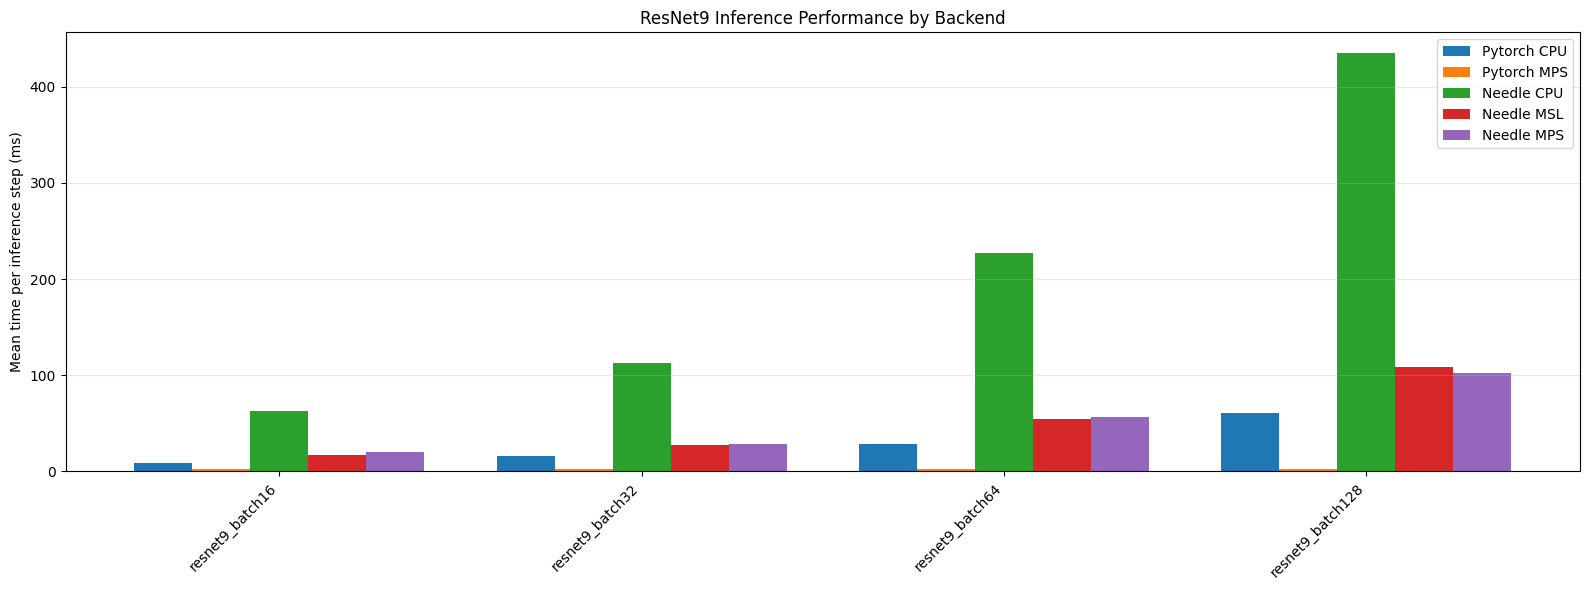

In [31]:
plot_resnet9_mean_ms_grouped(df_resnet9, only_needle=False, show_needle_cpu=True)